In [1]:
import numpy as np
import math
import multiprocessing as mp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from collections import namedtuple

from PIL import Image
import os
import os.path
import errno
import codecs
import copy

In [2]:
torch.manual_seed(0)
np.random.seed(0)
print("torch.cuda.device_count()", torch.cuda.device_count())
print("torch.cuda.current_device()", torch.cuda.current_device())
torch.cuda.set_device(1)
print("torch.cuda.current_device()", torch.cuda.current_device())

torch.cuda.device_count() 4
torch.cuda.current_device() 0
torch.cuda.current_device() 1


In [3]:
def compute_ranks(x):
  """
  Returns ranks in [0, len(x))
  Note: This is different from scipy.stats.rankdata, which returns ranks in [1, len(x)].
  (https://github.com/openai/evolution-strategies-starter/blob/master/es_distributed/es.py)
  """
  assert x.ndim == 1
  ranks = np.empty(len(x), dtype=int)
  ranks[x.argsort()] = np.arange(len(x))
  return ranks

def compute_centered_ranks(x):
  """
  https://github.com/openai/evolution-strategies-starter/blob/master/es_distributed/es.py
  """
  y = compute_ranks(x.ravel()).reshape(x.shape).astype(np.float32)
  y /= (x.size - 1)
  y -= .5
  return y

def compute_weight_decay(weight_decay, model_param_list):
  model_param_grid = np.array(model_param_list)
  return - weight_decay * np.mean(model_param_grid * model_param_grid, axis=1)

class CMAES:
  '''CMA-ES wrapper.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.10,       # initial standard deviation
               popsize=255):          # population size

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.popsize = popsize

    self.solutions = None

    import cma
    self.es = cma.CMAEvolutionStrategy( self.num_params * [0],
                                        self.sigma_init,
                                        {'popsize': self.popsize})

  def rms_stdev(self):
    sigma = self.es.result()[6]
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    self.solutions = np.array(self.es.ask())
    return self.solutions

  def tell(self, reward_table_result):
    reward_table = reward_table_result
    self.es.tell(self.solutions, (-reward_table).tolist()) # convert minimizer to maximizer.

  def done(self):
    return self.es.stop()

  def current_param(self):
    return self.es.result()[5] # mean solution, presumably better with noise
  
  def best_param(self):
    return self.es.result()[0] # best evaluated solution

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    r = self.es.result()
    return (r[0], -r[1], -r[1], r[6])

class SimpleES:
  '''Simple Evolution Strategies.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.10,       # initial standard deviation
               sigma_alpha=0.20,      # learning rate for standard deviation
               sigma_decay=0.999,     # anneal standard deviation
               sigma_limit=0.01,      # stop annealing if less than this
               popsize=255,           # population size
               elite_ratio=0.1,       # percentage of the elites
               done_threshold=1e-6,   # threshold when we say we are done
               average_baseline=True, # set baseline to average of batch
               forget_best=True):     # only use the best from latest generation

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.sigma_alpha = sigma_alpha
    self.sigma_decay = sigma_decay
    self.sigma_limit = sigma_limit
    self.popsize = popsize
    self.average_baseline = average_baseline
    if self.average_baseline:
      assert (self.popsize & 2), "Population size must be even"
      self.batch_size = int(self.popsize / 2)
    else:
      assert (self.popsize & 1), "Population size must be odd"
      self.batch_size = int((self.popsize - 1) / 2)
    self.elite_ratio = elite_ratio
    self.elite_popsize = int(self.popsize * self.elite_ratio)
    self.forget_best = forget_best
    self.batch_reward = np.zeros(self.batch_size * 2)
    self.mu = np.zeros(self.num_params)
    self.sigma = np.ones(self.num_params) * self.sigma_init
    self.curr_best_mu = np.zeros(self.num_params)
    self.best_mu = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_interation = True
    self.done_threshold = done_threshold

  def rms_stdev(self):
    sigma = self.sigma
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    # antithetic sampling
    self.epsilon = np.random.randn(self.batch_size, self.num_params) * self.sigma.reshape(1, self.num_params)
    self.epsilon_full = np.concatenate([self.epsilon, - self.epsilon])
    if self.average_baseline:
      epsilon = self.epsilon_full
    else:
      # first population is mu, then positive epsilon, then negative epsilon
      epsilon = np.concatenate([np.zeros((1, self.num_params)), self.epsilon_full])
    solutions = self.mu.reshape(1, self.num_params) + epsilon
    return solutions

  def tell(self, reward_table_result):
    # input must be a numpy float array
    assert(len(reward_table_result) == self.popsize), "Inconsistent reward_table size reported."

    reward_table = reward_table_result

    reward_offset = 1
    if self.average_baseline:
      b = np.mean(reward_table)
      reward_offset = 0
    else:
      b = reward_table[0] # baseline
      
    reward = reward_table[reward_offset:]
    idx = np.argsort(reward)[::-1][0:self.elite_popsize]

    best_reward = reward[idx[0]]
    if (best_reward > b or self.average_baseline):
      best_mu = self.mu + self.epsilon_full[idx[0]]
      best_reward = reward[idx[0]]
    else:
      best_mu = self.mu
      best_reward = b

    self.curr_best_reward = best_reward
    self.curr_best_mu = best_mu

    if self.first_interation:
      self.first_interation = False
      self.best_reward = self.curr_best_reward
      self.best_mu = best_mu
    else:
      if self.forget_best or (self.curr_best_reward > self.best_reward):
        self.best_mu = best_mu
        self.best_reward = self.curr_best_reward

    # adaptive sigma
    # normalization
    stdev_reward = reward.std()
    epsilon = self.epsilon
    sigma = self.sigma
    S = ((epsilon * epsilon - (sigma * sigma).reshape(1, self.num_params)) / sigma.reshape(1, self.num_params))
    reward_avg = (reward[:self.batch_size] + reward[self.batch_size:]) / 2.0
    rS = reward_avg - b
    delta_sigma = (np.dot(rS, S)) / (2 * self.batch_size * stdev_reward)

    # move mean to the average of the best idx means
    self.mu += self.epsilon_full[idx].mean(axis=0)

    # adjust sigma according to the adaptive sigma calculation
    change_sigma = self.sigma_alpha * delta_sigma
    change_sigma = np.minimum(change_sigma, self.sigma)
    change_sigma = np.maximum(change_sigma, - 0.5 * self.sigma)
    self.sigma += change_sigma
    self.sigma[self.sigma > self.sigma_limit] *= self.sigma_decay

  def done(self):
    return (self.rms_stdev() < self.done_threshold)

  def current_param(self):
    return self.curr_best_mu
  
  def best_param(self):
    return self.best_mu

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_mu, self.best_reward, self.curr_best_reward, self.sigma)

class SimpleGA:
  '''Simple Genetic Algorithm.'''
  def __init__(self, num_params,      # number of model parameters
               sigma_init=0.1,        # initial standard deviation
               sigma_decay=0.999,     # anneal standard deviation
               sigma_limit=0.01,      # stop annealing if less than this
               popsize=255,           # population size
               elite_ratio=0.1,       # percentage of the elites
               forget_best=True,      # forget the historical best elites
               done_threshold=1e-6):  # threshold when we say we are done

    self.num_params = num_params
    self.sigma_init = sigma_init
    self.sigma_decay = sigma_decay
    self.sigma_limit = sigma_limit
    self.popsize = popsize

    self.elite_ratio = elite_ratio
    self.elite_popsize = int(self.popsize * self.elite_ratio)

    self.sigma = self.sigma_init
    self.elite_params = np.zeros((self.elite_popsize, self.num_params))
    self.elite_rewards = np.zeros(self.elite_popsize)
    self.best_param = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_iteration = True
    self.forget_best = forget_best
    self.done_threshold = done_threshold

  def rms_stdev(self):
    return self.sigma # same sigma for all parameters.

  def ask(self):
    '''returns a list of parameters'''
    # antithetic sampling
    self.epsilon = np.random.randn(self.popsize, self.num_params) * self.sigma
    solutions = []
    
    def mate(a, b):
      c = np.copy(a)
      idx = np.where(np.random.rand((c.size)) > 0.5)
      c[idx] = b[idx]
      return c
    
    elite_range = range(self.elite_popsize)
    for i in range(self.popsize):
      idx_a = np.random.choice(elite_range)
      idx_b = np.random.choice(elite_range)
      child_params = mate(self.elite_params[idx_a], self.elite_params[idx_b])
      solutions.append(child_params + self.epsilon[i])

    solutions = np.array(solutions)
    self.solutions = solutions

    return solutions

  def tell(self, reward_table_result):
    # input must be a numpy float array
    assert(len(reward_table_result) == self.popsize), "Inconsistent reward_table size reported."
    
    if (not forget_best or self.first_iteration):
      reward = reward_table_result
      solution = self.solutions
    else:
      reward = np.concatenate([reward_table_result, self.elite_rewards])
      solution = np.concatenate([self.solutions, self.elite_params])

    idx = np.argsort(reward)[::-1][0:self.elite_popsize]

    self.elite_rewards = reward[idx]
    self.elite_params = solution[idx]

    self.curr_best_reward = self.elite_rewards[0]
    
    if self.first_iteration or (self.curr_best_reward > self.best_reward):
      self.first_iteration = False
      self.best_reward = self.elite_rewards[0]
      self.best_param = np.copy(self.elite_params[0])

    if (self.sigma > self.sigma_limit):
      self.sigma *= self.sigma_decay

  def done(self):
    return (self.rms_stdev() < self.done_threshold)

  def current_param(self):
    return self.elite_params[0]

  def best_param(self):
    return self.best_param

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_param, self.best_reward, self.curr_best_reward, self.sigma)

class OpenES:
  ''' Basic Version of OpenAI Evolution Strategies.'''
  def __init__(self, num_params,             # number of model parameters
               sigma_init=0.1,               # initial standard deviation
               sigma_decay=0.999,            # anneal standard deviation
               sigma_limit=0.01,             # stop annealing if less than this
               learning_rate=0.001,          # learning rate for standard deviation
               learning_rate_decay = 0.9999, # annealing the learning rate
               learning_rate_limit = 0.001,  # stop annealing learning rate
               popsize=255,                  # population size
               antithetic=False,             # whether to use antithetic sampling
               forget_best=True):           # forget historical best

    self.num_params = num_params
    self.sigma_decay = sigma_decay
    self.sigma = sigma_init
    self.sigma_limit = sigma_limit
    self.learning_rate = learning_rate
    self.learning_rate_decay = learning_rate_decay
    self.learning_rate_limit = learning_rate_limit
    self.popsize = popsize
    self.antithetic = antithetic
    if self.antithetic:
      assert (self.popsize & 2), "Population size must be even"
      self.half_popsize = int(self.popsize / 2)

    self.reward = np.zeros(self.popsize)
    self.mu = np.zeros(self.num_params)
    self.best_mu = np.zeros(self.num_params)
    self.best_reward = 0
    self.first_interation = True
    self.forget_best = forget_best

  def rms_stdev(self):
    sigma = self.sigma
    return np.mean(np.sqrt(sigma*sigma))

  def ask(self):
    '''returns a list of parameters'''
    # antithetic sampling
    if self.antithetic:
      self.epsilon_half = np.random.randn(self.half_popsize, self.num_params)
      self.epsilon = np.concatenate([self.epsilon_half, - self.epsilon_half])
    else:
      self.epsilon = np.random.randn(self.popsize, self.num_params)

    self.solutions = self.mu.reshape(1, self.num_params) + self.epsilon * self.sigma

    return self.solutions

  def tell(self, reward):
    # input must be a numpy float array
    assert(len(reward) == self.popsize), "Inconsistent reward_table size reported."

    idx = np.argsort(reward)[::-1]

    best_reward = reward[idx[0]]
    best_mu = self.solutions[idx[0]]

    self.curr_best_reward = best_reward
    self.curr_best_mu = best_mu

    if self.first_interation:
      self.first_interation = False
      self.best_reward = self.curr_best_reward
      self.best_mu = best_mu
    else:
      if self.forget_best or (self.curr_best_reward > self.best_reward):
        self.best_mu = best_mu
        self.best_reward = self.curr_best_reward

    # main bit:
    # standardize the rewards to have a gaussian distribution
    normalized_reward = (reward - np.mean(reward)) / np.std(reward)
    self.mu += self.learning_rate/(self.popsize*self.sigma)*np.dot(self.epsilon.T, normalized_reward)

    # adjust sigma according to the adaptive sigma calculation
    if (self.sigma > self.sigma_limit):
      self.sigma *= self.sigma_decay

    if (self.learning_rate > self.learning_rate_limit):
      self.learning_rate *= self.learning_rate_decay

  def done(self):
    return False

  def current_param(self):
    return self.curr_best_mu

  def best_param(self):
    return self.best_mu

  def result(self): # return best params so far, along with historically best reward, curr reward, sigma
    return (self.best_mu, self.best_reward, self.curr_best_reward, self.sigma)

In [4]:
Args = namedtuple('Args', ['batch_size', 'test_batch_size', 'epochs', 'lr', 'cuda', 'seed', 'log_interval'])

In [5]:
args = Args(batch_size=1000, test_batch_size=1000, epochs=30, lr=0.001, cuda=True, seed=0, log_interval=10)

In [6]:
torch.manual_seed(args.seed)
if args.cuda:
  torch.cuda.manual_seed(args.seed)

In [7]:
kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('MNIST_data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=args.batch_size, shuffle=True, **kwargs)

valid_loader = train_loader

test_loader = torch.utils.data.DataLoader(
  datasets.MNIST('MNIST_data', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])),
  batch_size=args.batch_size, shuffle=True, **kwargs)

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.num_filter1 = 8
    self.num_filter2 = 16
    self.num_padding = 2
    # input is 28x28
    # padding=2 for same padding
    self.conv1 = nn.Conv2d(1, self.num_filter1, 5, padding=self.num_padding)
    # feature map size is 14*14 by pooling
    # padding=2 for same padding
    self.conv2 = nn.Conv2d(self.num_filter1, self.num_filter2, 5, padding=self.num_padding)
    # feature map size is 7*7 by pooling
    self.fc = nn.Linear(self.num_filter2*7*7, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), 2)
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_filter2*7*7)   # reshape Variable
    x = self.fc(x)
    return F.log_softmax(x)

In [9]:
NPOPULATION = 101
weight_decay_coef = 0.1

In [10]:
'''
models = []
for i in range(NPOPULATION):
  model = Net()
  if args.cuda:
    model.cuda()
  model.eval()
  models.append(model)
'''

model = Net()
if args.cuda:
  model.cuda()

orig_model = copy.deepcopy(model)

In [11]:
# get init params
orig_params = []
model_shapes = []
for param in orig_model.parameters():
  p = param.data.cpu().numpy()
  model_shapes.append(p.shape)
  orig_params.append(p.flatten())
orig_params_flat = np.concatenate(orig_params)
NPARAMS = len(orig_params_flat)
print(NPARAMS)

11274


In [12]:
def update_model(flat_param, model, model_shapes):
  idx = 0
  i = 0
  for param in model.parameters():
    delta = np.product(model_shapes[i])
    block = flat_param[idx:idx+delta]
    block = np.reshape(block, model_shapes[i])
    i += 1
    idx += delta
    block_data = torch.from_numpy(block).float()
    if args.cuda:
      block_data = block_data.cuda()
    param.data = block_data

In [13]:
def evaluate(model, test_loader, print_mode=True, return_loss=False):
  model.eval()
  test_loss = 0
  correct = 0
  for data, target in test_loader:
    if args.cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
    correct += pred.eq(target.data.view_as(pred)).cpu().sum()

  test_loss /= len(test_loader.dataset)
  acc = correct / len(test_loader.dataset)
  
  if print_mode:
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * acc))
  
  if return_loss:
    return test_loss
  return acc

In [17]:
"""
es = SimpleES(NPARAMS,
              popsize=NPOPULATION,
              sigma_init=0.01,
              sigma_decay=0.999,
              sigma_alpha=0.2,
              sigma_limit=0.001,
              elite_ratio=0.1,
              average_baseline=False,
              forget_best=True
             )
"""
es = OpenES(NPARAMS,
              popsize=NPOPULATION,
              sigma_init=0.01,
              sigma_decay=0.999,
              sigma_limit=0.01,
              forget_best=False,
              learning_rate=0.001,
              learning_rate_decay = 0.9999,
              learning_rate_limit = 0.0001,
             )

In [18]:
def worker(procnum, model, solution, data, target, send_end):
  update_model(solution, model, model_shapes)
  output = model(data)
  loss = F.nll_loss(output, target)
  reward = - loss.data[0]
  send_end.send(reward)

def batch_simulation(model_list, solutions, data, target, process_count):
  jobs = []
  pipe_list = []

  for i in range(process_count):
    recv_end, send_end = mp.Pipe(False)
    p = mp.Process(target=worker, args=(i, model_list[i], solutions[i], data, target, send_end))
    jobs.append(p)
    pipe_list.append(recv_end)

  for p in jobs:
    p.start()

  for p in jobs:
    p.join()

  result_list = [x.recv() for x in pipe_list]
  return np.array(result_list)


def batch_simulation_sequential(model_list, solutions, data, target, process_count):
  result_list = []
  for i in range(process_count):
    update_model(solutions[i], model_list[i], model_shapes)
    output = model_list[i](data)
    loss = F.nll_loss(output, target)
    reward = - loss.data[0]
    result_list.append(reward)
  return np.array(result_list)


In [19]:
#'''
best_valid_acc = 0
training_log = []
for epoch in range(1, 10*args.epochs + 1):

  # train loop
  model.eval()
  for batch_idx, (data, target) in enumerate(train_loader):
    if args.cuda:
      data, target = data.cuda(), target.cuda()
    data, target = Variable(data), Variable(target)
    
    solutions = es.ask()
    reward = np.zeros(es.popsize)
    
    for i in range(es.popsize):
      update_model(solutions[i], model, model_shapes)
      output = model(data)
      loss = F.nll_loss(output, target)
      reward[i] = - loss.data[0]

    best_raw_reward = reward.max()
    #reward = compute_centered_ranks(reward)
    l2_decay = compute_weight_decay(weight_decay_coef, solutions)
    reward += l2_decay

    es.tell(reward)

    result = es.result()
    
    if (batch_idx % 5 == 0):
      print(epoch, batch_idx, best_raw_reward, result[0].mean(), result[3])

  curr_solution = es.current_param()
  update_model(curr_solution, model, model_shapes)

  valid_acc = evaluate(model, valid_loader, print_mode=False)
  training_log.append([epoch, valid_acc])
  print('valid_acc', valid_acc * 100.)
  if valid_acc >= best_valid_acc:
    best_valid_acc = valid_acc
    best_model = copy.deepcopy(model)
    print('best valid_acc', best_valid_acc * 100.)
#'''

1 0 -2.30193543434 -7.93079584148e-05 0.01
1 5 -2.25925588608 0.000434028402925 0.01
1 10 -1.88105452061 0.000863433082393 0.01
1 15 -1.42825007439 0.00091040908483 0.01
1 20 -1.19715201855 0.000916270582721 0.01
1 25 -1.08275806904 0.000974892798043 0.01
1 30 -0.983183026314 0.00104386101784 0.01
1 35 -0.919698655605 0.000678370184286 0.01
1 40 -0.844817101955 0.000926555426733 0.01
1 45 -0.817394971848 0.000922090877786 0.01
1 50 -0.814984381199 0.00116070012036 0.01
1 55 -0.805679738522 0.00116070012036 0.01
valid_acc 74.995
best valid_acc 74.995
2 0 -0.84048551321 0.00116070012036 0.01
2 5 -0.790781915188 0.00128451260662 0.01
2 10 -0.77977091074 0.00128451260662 0.01
2 15 -0.741036474705 0.00128451260662 0.01
2 20 -0.7792776227 0.00123299907838 0.01
2 25 -0.75918161869 0.00123299907838 0.01
2 30 -0.747699975967 0.00123299907838 0.01
2 35 -0.720850110054 0.00123299907838 0.01
2 40 -0.724429726601 0.00123299907838 0.01
2 45 -0.742388427258 0.00123299907838 0.01
2 50 -0.724133014679 

15 15 -0.278257846832 -0.0022941715027 0.01
15 20 -0.199897810817 -0.0022941715027 0.01
15 25 -0.324608832598 -0.0022941715027 0.01
15 30 -0.264069467783 -0.0022941715027 0.01
15 35 -0.313965886831 -0.0022941715027 0.01
15 40 -0.222511783242 -0.0022941715027 0.01
15 45 -0.281480938196 -0.0022941715027 0.01
15 50 -0.315714657307 -0.0022941715027 0.01
15 55 -0.33135831356 -0.0022941715027 0.01
valid_acc 92.34166666666667
16 0 -0.258548766375 -0.0022941715027 0.01
16 5 -0.259231090546 -0.0022941715027 0.01
16 10 -0.268146544695 -0.0022941715027 0.01
16 15 -0.256642192602 -0.0022941715027 0.01
16 20 -0.262843906879 -0.0022941715027 0.01
16 25 -0.364241272211 -0.0022941715027 0.01
16 30 -0.286819070578 -0.0022941715027 0.01
16 35 -0.245955079794 -0.0022941715027 0.01
16 40 -0.269758284092 -0.0022941715027 0.01
16 45 -0.1967754215 -0.0022941715027 0.01
16 50 -0.267617791891 -0.0022941715027 0.01
16 55 -0.26230725646 -0.0022941715027 0.01
valid_acc 92.84
best valid_acc 92.84
17 0 -0.241725966

29 50 -0.245892882347 -0.00897767808967 0.01
29 55 -0.307585507631 -0.00897767808967 0.01
valid_acc 92.21000000000001
30 0 -0.328957676888 -0.00897767808967 0.01
30 5 -0.333094775677 -0.00897767808967 0.01
30 10 -0.379304200411 -0.00897767808967 0.01
30 15 -0.317972660065 -0.00897767808967 0.01
30 20 -0.343192368746 -0.00897767808967 0.01
30 25 -0.230095252395 -0.00897767808967 0.01
30 30 -0.309866577387 -0.00897767808967 0.01
30 35 -0.324126899242 -0.00897767808967 0.01
30 40 -0.301585644484 -0.00897767808967 0.01
30 45 -0.270292252302 -0.00897767808967 0.01
30 50 -0.268347501755 -0.00897767808967 0.01
30 55 -0.240454316139 -0.00897767808967 0.01
valid_acc 92.485
31 0 -0.250479251146 -0.00897767808967 0.01
31 5 -0.320560693741 -0.00897767808967 0.01
31 10 -0.244169145823 -0.00897767808967 0.01
31 15 -0.26286098361 -0.00897767808967 0.01
31 20 -0.348679602146 -0.00897767808967 0.01
31 25 -0.265049010515 -0.00897767808967 0.01
31 30 -0.223200544715 -0.00897767808967 0.01
31 35 -0.273916

44 30 -0.27457678318 -0.0108712821164 0.01
44 35 -0.24832201004 -0.0108712821164 0.01
44 40 -0.257895290852 -0.0108712821164 0.01
44 45 -0.228023424745 -0.0108712821164 0.01
44 50 -0.313565999269 -0.0108712821164 0.01
44 55 -0.240123018622 -0.0108712821164 0.01
valid_acc 93.30166666666668
45 0 -0.237836867571 -0.0108712821164 0.01
45 5 -0.266578286886 -0.0108712821164 0.01
45 10 -0.215850368142 -0.0108712821164 0.01
45 15 -0.220849618316 -0.0108712821164 0.01
45 20 -0.297386527061 -0.0108712821164 0.01
45 25 -0.2593331635 -0.0108712821164 0.01
45 30 -0.251933515072 -0.0108712821164 0.01
45 35 -0.235688343644 -0.0108712821164 0.01
45 40 -0.260635703802 -0.0108712821164 0.01
45 45 -0.294754296541 -0.0108712821164 0.01
45 50 -0.220173612237 -0.0108712821164 0.01
45 55 -0.284907609224 -0.0108712821164 0.01
valid_acc 93.48333333333333
46 0 -0.209788009524 -0.0108712821164 0.01
46 5 -0.204026699066 -0.0108712821164 0.01
46 10 -0.244791358709 -0.0108712821164 0.01
46 15 -0.218293875456 -0.010

59 25 -0.213397368789 -0.0108712821164 0.01
59 30 -0.22652952373 -0.0108712821164 0.01
59 35 -0.286773502827 -0.0108712821164 0.01
59 40 -0.237349167466 -0.0108712821164 0.01
59 45 -0.244044244289 -0.0108712821164 0.01
59 50 -0.301280230284 -0.0108712821164 0.01
59 55 -0.214439332485 -0.0108712821164 0.01
valid_acc 93.21333333333334
60 0 -0.163309052587 -0.0108712821164 0.01
60 5 -0.242734640837 -0.0108712821164 0.01
60 10 -0.220659732819 -0.0108712821164 0.01
60 15 -0.19724200666 -0.0108712821164 0.01
60 20 -0.240264981985 -0.0108712821164 0.01
60 25 -0.136334955692 -0.0191175899505 0.01
60 30 -0.274516046047 -0.0191175899505 0.01
60 35 -0.156088724732 -0.0191175899505 0.01
60 40 -0.261621922255 -0.0191175899505 0.01
60 45 -0.258485227823 -0.0191175899505 0.01
60 50 -0.188260540366 -0.0191175899505 0.01
60 55 -0.226174801588 -0.0191175899505 0.01
valid_acc 93.34
61 0 -0.249201193452 -0.0191175899505 0.01
61 5 -0.267886340618 -0.0191175899505 0.01
61 10 -0.200730159879 -0.0191175899505

74 25 -0.259078204632 -0.0191175899505 0.01
74 30 -0.228176176548 -0.0191175899505 0.01
74 35 -0.235839188099 -0.0191175899505 0.01
74 40 -0.266179889441 -0.0191175899505 0.01
74 45 -0.190561041236 -0.0191175899505 0.01
74 50 -0.233552828431 -0.0191175899505 0.01
74 55 -0.263083040714 -0.0191175899505 0.01
valid_acc 93.515
75 0 -0.220613434911 -0.0191175899505 0.01
75 5 -0.247496455908 -0.0191175899505 0.01
75 10 -0.256971925497 -0.0191175899505 0.01
75 15 -0.214274391532 -0.0191175899505 0.01
75 20 -0.179808810353 -0.0191175899505 0.01
75 25 -0.175790831447 -0.0191175899505 0.01
75 30 -0.188938781619 -0.0191175899505 0.01
75 35 -0.2292381078 -0.0191175899505 0.01
75 40 -0.20284357667 -0.0191175899505 0.01
75 45 -0.202714696527 -0.0191175899505 0.01
75 50 -0.212022021413 -0.0191175899505 0.01
75 55 -0.222170129418 -0.0191175899505 0.01
valid_acc 93.51
76 0 -0.225315734744 -0.0191175899505 0.01
76 5 -0.287837862968 -0.0191175899505 0.01
76 10 -0.241556614637 -0.0191175899505 0.01
76 15 

89 25 -0.244201749563 -0.0215318731065 0.01
89 30 -0.19055852294 -0.0215318731065 0.01
89 35 -0.190534293652 -0.0215318731065 0.01
89 40 -0.242186620831 -0.0215318731065 0.01
89 45 -0.189205765724 -0.0215318731065 0.01
89 50 -0.225952684879 -0.0215318731065 0.01
89 55 -0.199784994125 -0.0215318731065 0.01
valid_acc 93.82666666666667
90 0 -0.256474584341 -0.0215318731065 0.01
90 5 -0.213735803962 -0.0215318731065 0.01
90 10 -0.175726428628 -0.0215318731065 0.01
90 15 -0.217112720013 -0.0215318731065 0.01
90 20 -0.213605433702 -0.0215318731065 0.01
90 25 -0.19825387001 -0.0215318731065 0.01
90 30 -0.215885534883 -0.0215318731065 0.01
90 35 -0.214866876602 -0.0215318731065 0.01
90 40 -0.198032304645 -0.0215318731065 0.01
90 45 -0.29971820116 -0.0215318731065 0.01
90 50 -0.202042281628 -0.0215318731065 0.01
90 55 -0.20987123251 -0.0215318731065 0.01
valid_acc 93.895
91 0 -0.195534080267 -0.0215318731065 0.01
91 5 -0.223617047071 -0.0215318731065 0.01
91 10 -0.240793079138 -0.0215318731065 

104 15 -0.146793410182 -0.0215318731065 0.01
104 20 -0.216696515679 -0.0215318731065 0.01
104 25 -0.191189929843 -0.0215318731065 0.01
104 30 -0.211047053337 -0.0215318731065 0.01
104 35 -0.225903883576 -0.0215318731065 0.01
104 40 -0.173151060939 -0.0215318731065 0.01
104 45 -0.19538629055 -0.0215318731065 0.01
104 50 -0.265716224909 -0.0215318731065 0.01
104 55 -0.169058874249 -0.0215318731065 0.01
valid_acc 94.395
105 0 -0.202189221978 -0.0215318731065 0.01
105 5 -0.153549075127 -0.0215318731065 0.01
105 10 -0.225426539779 -0.0215318731065 0.01
105 15 -0.196210041642 -0.0215318731065 0.01
105 20 -0.157882213593 -0.0215318731065 0.01
105 25 -0.24745836854 -0.0215318731065 0.01
105 30 -0.184742003679 -0.0215318731065 0.01
105 35 -0.180968463421 -0.0215318731065 0.01
105 40 -0.206878036261 -0.0215318731065 0.01
105 45 -0.212488904595 -0.0215318731065 0.01
105 50 -0.199648231268 -0.0215318731065 0.01
105 55 -0.196348875761 -0.0215318731065 0.01
valid_acc 93.785
106 0 -0.251279383898 -0.

118 55 -0.2226780653 -0.0225759469157 0.01
valid_acc 94.52166666666668
119 0 -0.158425554633 -0.0225759469157 0.01
119 5 -0.164349287748 -0.0225759469157 0.01
119 10 -0.231805607677 -0.0225759469157 0.01
119 15 -0.160710275173 -0.0225759469157 0.01
119 20 -0.229204460979 -0.0225759469157 0.01
119 25 -0.145065844059 -0.0225759469157 0.01
119 30 -0.203490838408 -0.0225759469157 0.01
119 35 -0.172706618905 -0.0225759469157 0.01
119 40 -0.186062529683 -0.0225759469157 0.01
119 45 -0.258815050125 -0.0225759469157 0.01
119 50 -0.158574491739 -0.0225759469157 0.01
119 55 -0.173708096147 -0.0225759469157 0.01
valid_acc 94.38333333333333
120 0 -0.204703211784 -0.0225759469157 0.01
120 5 -0.261439740658 -0.0225759469157 0.01
120 10 -0.173525840044 -0.0225759469157 0.01
120 15 -0.162208214402 -0.0225759469157 0.01
120 20 -0.194895520806 -0.0225759469157 0.01
120 25 -0.181664302945 -0.0225759469157 0.01
120 30 -0.158372193575 -0.0225759469157 0.01
120 35 -0.155544102192 -0.0225759469157 0.01
120 4

133 30 -0.13133828342 -0.0225759469157 0.01
133 35 -0.209300756454 -0.0225759469157 0.01
133 40 -0.192356705666 -0.0225759469157 0.01
133 45 -0.132788211107 -0.0225759469157 0.01
133 50 -0.156998261809 -0.0225759469157 0.01
133 55 -0.195408523083 -0.0225759469157 0.01
valid_acc 94.12
134 0 -0.204708591104 -0.0225759469157 0.01
134 5 -0.174416705966 -0.0225759469157 0.01
134 10 -0.246588528156 -0.0225759469157 0.01
134 15 -0.175597026944 -0.0225759469157 0.01
134 20 -0.19856582582 -0.0225759469157 0.01
134 25 -0.209628343582 -0.0225759469157 0.01
134 30 -0.228818997741 -0.0225759469157 0.01
134 35 -0.20964255929 -0.0225759469157 0.01
134 40 -0.142123937607 -0.0225759469157 0.01
134 45 -0.147014886141 -0.0225759469157 0.01
134 50 -0.188979208469 -0.0225759469157 0.01
134 55 -0.158431574702 -0.0225759469157 0.01
valid_acc 94.52833333333334
135 0 -0.143948197365 -0.0225759469157 0.01
135 5 -0.206586197019 -0.0225759469157 0.01
135 10 -0.189410045743 -0.0225759469157 0.01
135 15 -0.18663136

valid_acc 94.16166666666666
148 0 -0.148230046034 -0.0234796466309 0.01
148 5 -0.16827686131 -0.0234796466309 0.01
148 10 -0.132015407085 -0.0234796466309 0.01
148 15 -0.19954675436 -0.0234796466309 0.01
148 20 -0.224714025855 -0.0234796466309 0.01
148 25 -0.211595863104 -0.0234796466309 0.01
148 30 -0.175767824054 -0.0234796466309 0.01
148 35 -0.168140023947 -0.0234796466309 0.01
148 40 -0.255227148533 -0.0234796466309 0.01
148 45 -0.222752228379 -0.0234796466309 0.01
148 50 -0.13370577991 -0.0234796466309 0.01
148 55 -0.236403152347 -0.0234796466309 0.01
valid_acc 94.485
149 0 -0.189185321331 -0.0234796466309 0.01
149 5 -0.148595631123 -0.0234796466309 0.01
149 10 -0.19100612402 -0.0234796466309 0.01
149 15 -0.251616001129 -0.0234796466309 0.01
149 20 -0.179991602898 -0.0234796466309 0.01
149 25 -0.172723844647 -0.0234796466309 0.01
149 30 -0.183736979961 -0.0234796466309 0.01
149 35 -0.18945646286 -0.0234796466309 0.01
149 40 -0.155259564519 -0.0234796466309 0.01
149 45 -0.152549624

162 25 -0.165348127484 -0.0234796466309 0.01
162 30 -0.157969623804 -0.0234796466309 0.01
162 35 -0.151905089617 -0.0234796466309 0.01
162 40 -0.155960544944 -0.0234796466309 0.01
162 45 -0.205649763346 -0.0234796466309 0.01
162 50 -0.200730413198 -0.0234796466309 0.01
162 55 -0.169504448771 -0.0234796466309 0.01
valid_acc 94.845
163 0 -0.218370974064 -0.0234796466309 0.01
163 5 -0.14111559093 -0.0234796466309 0.01
163 10 -0.168515384197 -0.0234796466309 0.01
163 15 -0.184047743678 -0.0234796466309 0.01
163 20 -0.205112442374 -0.0234796466309 0.01
163 25 -0.168580159545 -0.0234796466309 0.01
163 30 -0.166560038924 -0.0234796466309 0.01
163 35 -0.125827923417 -0.0234796466309 0.01
163 40 -0.170971661806 -0.0234796466309 0.01
163 45 -0.160611331463 -0.0234796466309 0.01
163 50 -0.158219814301 -0.0234796466309 0.01
163 55 -0.229155004025 -0.0234796466309 0.01
valid_acc 94.95166666666667
164 0 -0.186562716961 -0.0234796466309 0.01
164 5 -0.172519266605 -0.0234796466309 0.01
164 10 -0.15318

176 55 -0.129296720028 -0.0255046946751 0.01
valid_acc 94.77333333333333
177 0 -0.180397331715 -0.0255046946751 0.01
177 5 -0.150705620646 -0.0255046946751 0.01
177 10 -0.15338280797 -0.0255046946751 0.01
177 15 -0.148124963045 -0.0255046946751 0.01
177 20 -0.176832079887 -0.0255046946751 0.01
177 25 -0.254689991474 -0.0255046946751 0.01
177 30 -0.203389823437 -0.0255046946751 0.01
177 35 -0.166807129979 -0.0255046946751 0.01
177 40 -0.16334412992 -0.0255046946751 0.01
177 45 -0.135880485177 -0.0255046946751 0.01
177 50 -0.159860208631 -0.0255046946751 0.01
177 55 -0.121558494866 -0.0255046946751 0.01
valid_acc 95.24000000000001
best valid_acc 95.24000000000001
178 0 -0.158327043056 -0.0255046946751 0.01
178 5 -0.159377977252 -0.0255046946751 0.01
178 10 -0.150695458055 -0.0255046946751 0.01
178 15 -0.208715304732 -0.0255046946751 0.01
178 20 -0.121600233018 -0.0255046946751 0.01
178 25 -0.171353131533 -0.0255046946751 0.01
178 30 -0.158432483673 -0.0255046946751 0.01
178 35 -0.1393726

191 25 -0.161113142967 -0.0239676150554 0.01
191 30 -0.144841492176 -0.0239676150554 0.01
191 35 -0.177160292864 -0.0239676150554 0.01
191 40 -0.128405898809 -0.0239676150554 0.01
191 45 -0.154437422752 -0.0239676150554 0.01
191 50 -0.125113636255 -0.0239676150554 0.01
191 55 -0.148060277104 -0.0239676150554 0.01
valid_acc 94.94166666666666
192 0 -0.143423721194 -0.0239676150554 0.01
192 5 -0.162306278944 -0.0239676150554 0.01
192 10 -0.185855984688 -0.0239676150554 0.01
192 15 -0.12891818583 -0.0239676150554 0.01
192 20 -0.15031671524 -0.0239676150554 0.01
192 25 -0.188611581922 -0.0239676150554 0.01
192 30 -0.13440836966 -0.0239676150554 0.01
192 35 -0.167601138353 -0.0239676150554 0.01
192 40 -0.182400882244 -0.0239676150554 0.01
192 45 -0.17520429194 -0.0239676150554 0.01
192 50 -0.197066470981 -0.0239676150554 0.01
192 55 -0.175356969237 -0.0239676150554 0.01
valid_acc 95.25166666666667
193 0 -0.134393304586 -0.0239676150554 0.01
193 5 -0.197366684675 -0.0239676150554 0.01
193 10 

205 55 -0.165195405483 -0.0239676150554 0.01
valid_acc 95.28
206 0 -0.167412832379 -0.0239676150554 0.01
206 5 -0.178414806724 -0.0239676150554 0.01
206 10 -0.105171330273 -0.0239676150554 0.01
206 15 -0.178330749273 -0.0239676150554 0.01
206 20 -0.150951102376 -0.0239676150554 0.01
206 25 -0.137670218945 -0.0239676150554 0.01
206 30 -0.174897164106 -0.0239676150554 0.01
206 35 -0.146595731378 -0.0239676150554 0.01
206 40 -0.184889897704 -0.0239676150554 0.01
206 45 -0.13753503561 -0.0239676150554 0.01
206 50 -0.188366010785 -0.0239676150554 0.01
206 55 -0.167907714844 -0.0239676150554 0.01
valid_acc 95.33
207 0 -0.13097769022 -0.0249063676327 0.01
207 5 -0.140952304006 -0.0249063676327 0.01
207 10 -0.140880212188 -0.0249063676327 0.01
207 15 -0.160347446799 -0.0249063676327 0.01
207 20 -0.180471986532 -0.0249063676327 0.01
207 25 -0.158102974296 -0.0249063676327 0.01
207 30 -0.161048710346 -0.0249063676327 0.01
207 35 -0.170021936297 -0.0249063676327 0.01
207 40 -0.14539141953 -0.0249

220 30 -0.101717576385 -0.0249063676327 0.01
220 35 -0.195905715227 -0.0249063676327 0.01
220 40 -0.16389349103 -0.0249063676327 0.01
220 45 -0.142488747835 -0.0249063676327 0.01
220 50 -0.159179285169 -0.0249063676327 0.01
220 55 -0.148891851306 -0.0249063676327 0.01
valid_acc 95.62666666666667
221 0 -0.138237148523 -0.0249063676327 0.01
221 5 -0.129331991076 -0.0249063676327 0.01
221 10 -0.156728819013 -0.0249063676327 0.01
221 15 -0.163242965937 -0.0249063676327 0.01
221 20 -0.143952772021 -0.0249063676327 0.01
221 25 -0.129672497511 -0.0249063676327 0.01
221 30 -0.135797783732 -0.0249063676327 0.01
221 35 -0.197747901082 -0.0249063676327 0.01
221 40 -0.150996655226 -0.0249063676327 0.01
221 45 -0.165629014373 -0.0249063676327 0.01
221 50 -0.164652958512 -0.0249063676327 0.01
221 55 -0.156802237034 -0.0249063676327 0.01
valid_acc 95.02833333333334
222 0 -0.124108538032 -0.0249063676327 0.01
222 5 -0.118837624788 -0.0249063676327 0.01
222 10 -0.149185866117 -0.0249063676327 0.01
222 

235 5 -0.181627035141 -0.0249063676327 0.01
235 10 -0.110576525331 -0.0249063676327 0.01
235 15 -0.100181497633 -0.0249063676327 0.01
235 20 -0.126646742225 -0.0249063676327 0.01
235 25 -0.11535679549 -0.0249063676327 0.01
235 30 -0.202055260539 -0.0249063676327 0.01
235 35 -0.127652511001 -0.0249063676327 0.01
235 40 -0.12426353991 -0.0249063676327 0.01
235 45 -0.131065040827 -0.0249063676327 0.01
235 50 -0.105633825064 -0.0249063676327 0.01
235 55 -0.120351530612 -0.0249063676327 0.01
valid_acc 95.48666666666666
236 0 -0.11313855648 -0.0249063676327 0.01
236 5 -0.103776231408 -0.0249063676327 0.01
236 10 -0.157857507467 -0.0249063676327 0.01
236 15 -0.161920636892 -0.0249063676327 0.01
236 20 -0.166388466954 -0.0249063676327 0.01
236 25 -0.117285624146 -0.0249063676327 0.01
236 30 -0.179581522942 -0.0249063676327 0.01
236 35 -0.164721265435 -0.0249063676327 0.01
236 40 -0.138758182526 -0.0249063676327 0.01
236 45 -0.168466478586 -0.0249063676327 0.01
236 50 -0.107165835798 -0.0249063

249 40 -0.141809910536 -0.0249063676327 0.01
249 45 -0.127720713615 -0.0249063676327 0.01
249 50 -0.125276342034 -0.0249063676327 0.01
249 55 -0.198367357254 -0.0249063676327 0.01
valid_acc 95.70666666666666
250 0 -0.144662976265 -0.0249063676327 0.01
250 5 -0.142772629857 -0.0249063676327 0.01
250 10 -0.109702937305 -0.0249063676327 0.01
250 15 -0.183019280434 -0.0249063676327 0.01
250 20 -0.137247920036 -0.0249063676327 0.01
250 25 -0.162184923887 -0.0249063676327 0.01
250 30 -0.12722826004 -0.0249063676327 0.01
250 35 -0.141092538834 -0.0249063676327 0.01
250 40 -0.166620984674 -0.0249063676327 0.01
250 45 -0.098625279963 -0.0249063676327 0.01
250 50 -0.163390368223 -0.0249063676327 0.01
250 55 -0.120421022177 -0.0249063676327 0.01
valid_acc 95.79833333333333
best valid_acc 95.79833333333333
251 0 -0.156445711851 -0.0249063676327 0.01
251 5 -0.120685838163 -0.0249063676327 0.01
251 10 -0.114889807999 -0.0249063676327 0.01
251 15 -0.136225283146 -0.0249063676327 0.01
251 20 -0.145243

264 5 -0.15713609755 -0.0249063676327 0.01
264 10 -0.140892252326 -0.0249063676327 0.01
264 15 -0.147079616785 -0.0249063676327 0.01
264 20 -0.117124319077 -0.0249063676327 0.01
264 25 -0.099180214107 -0.0249063676327 0.01
264 30 -0.100307010114 -0.0249063676327 0.01
264 35 -0.132666125894 -0.0249063676327 0.01
264 40 -0.11050054431 -0.0249063676327 0.01
264 45 -0.120886556804 -0.0249063676327 0.01
264 50 -0.167192861438 -0.0249063676327 0.01
264 55 -0.145652189851 -0.0249063676327 0.01
valid_acc 95.72833333333334
265 0 -0.158030420542 -0.0249063676327 0.01
265 5 -0.144122630358 -0.0249063676327 0.01
265 10 -0.123322874308 -0.0249063676327 0.01
265 15 -0.165191620588 -0.0249063676327 0.01
265 20 -0.109535142779 -0.0249063676327 0.01
265 25 -0.117244146764 -0.0249063676327 0.01
265 30 -0.109866060317 -0.0249063676327 0.01
265 35 -0.160352557898 -0.0249063676327 0.01
265 40 -0.124380886555 -0.0249063676327 0.01
265 45 -0.127737149596 -0.0249063676327 0.01
265 50 -0.0965594872832 -0.02490

278 40 -0.119548670948 -0.0249063676327 0.01
278 45 -0.124517157674 -0.0249063676327 0.01
278 50 -0.120659269392 -0.0249063676327 0.01
278 55 -0.118288077414 -0.0249063676327 0.01
valid_acc 95.755
279 0 -0.0916623771191 -0.0249063676327 0.01
279 5 -0.133765488863 -0.0249063676327 0.01
279 10 -0.146170154214 -0.0249063676327 0.01
279 15 -0.151219144464 -0.0249063676327 0.01
279 20 -0.112214706838 -0.0249063676327 0.01
279 25 -0.13818924129 -0.0249063676327 0.01
279 30 -0.164551153779 -0.0249063676327 0.01
279 35 -0.137941285968 -0.0249063676327 0.01
279 40 -0.133789926767 -0.0249063676327 0.01
279 45 -0.149082988501 -0.0249063676327 0.01
279 50 -0.121044188738 -0.0249063676327 0.01
279 55 -0.153039008379 -0.0249063676327 0.01
valid_acc 95.67999999999999
280 0 -0.147434949875 -0.0249063676327 0.01
280 5 -0.163510158658 -0.0249063676327 0.01
280 10 -0.111529782414 -0.0249063676327 0.01
280 15 -0.114677354693 -0.0249063676327 0.01
280 20 -0.153850287199 -0.0249063676327 0.01
280 25 -0.1360

293 20 -0.134934917092 -0.0249063676327 0.01
293 25 -0.131124719977 -0.0249063676327 0.01
293 30 -0.139846920967 -0.0249063676327 0.01
293 35 -0.15787473321 -0.0249063676327 0.01
293 40 -0.119491904974 -0.0249063676327 0.01
293 45 -0.127970591187 -0.0249063676327 0.01
293 50 -0.157705098391 -0.0249063676327 0.01
293 55 -0.104803062975 -0.0249063676327 0.01
valid_acc 95.73166666666667
294 0 -0.164887830615 -0.0249063676327 0.01
294 5 -0.108257979155 -0.0249063676327 0.01
294 10 -0.130477935076 -0.0249063676327 0.01
294 15 -0.121569700539 -0.0249063676327 0.01
294 20 -0.135665476322 -0.0249063676327 0.01
294 25 -0.107686392963 -0.0249063676327 0.01
294 30 -0.112809613347 -0.0249063676327 0.01
294 35 -0.108562335372 -0.0249063676327 0.01
294 40 -0.213281571865 -0.0249063676327 0.01
294 45 -0.0881291031837 -0.0249063676327 0.01
294 50 -0.137437671423 -0.0249063676327 0.01
294 55 -0.128516480327 -0.0249063676327 0.01
valid_acc 95.86166666666666
295 0 -0.130128920078 -0.0249063676327 0.01
29

In [20]:
evaluate(best_model, valid_loader, print_mode=True)


Average loss: 0.1493, Accuracy: 57571/60000 (95.9517%)



0.9595166666666667

In [21]:
evaluate(best_model, test_loader, print_mode=True)


Average loss: 0.1398, Accuracy: 9623/10000 (96.2300%)



0.9623

In [22]:
evaluate(best_model, train_loader, print_mode=True)


Average loss: 0.1493, Accuracy: 57571/60000 (95.9517%)



0.9595166666666667

In [23]:
update_model(es.best_param(), model, model_shapes)

In [24]:
evaluate(model, valid_loader, print_mode=True)


Average loss: 0.1689, Accuracy: 57364/60000 (95.6067%)



0.9560666666666666

In [25]:
evaluate(model, test_loader, print_mode=True)


Average loss: 0.1591, Accuracy: 9558/10000 (95.5800%)



0.9558

In [26]:
evaluate(model, train_loader, print_mode=True)


Average loss: 0.1689, Accuracy: 57364/60000 (95.6067%)



0.9560666666666666

In [27]:
update_model(es.current_param(), model, model_shapes)

In [28]:
evaluate(model, valid_loader, print_mode=True)


Average loss: 0.1554, Accuracy: 57321/60000 (95.5350%)



0.95535

In [29]:
evaluate(model, test_loader, print_mode=True)


Average loss: 0.1479, Accuracy: 9569/10000 (95.6900%)



0.9569

In [30]:
evaluate(model, train_loader, print_mode=True)


Average loss: 0.1554, Accuracy: 57321/60000 (95.5350%)



0.95535

In [31]:
eval_acc = evaluate(best_model, test_loader)
print('final test acc', eval_acc * 100.)


Average loss: 0.1398, Accuracy: 9623/10000 (96.2300%)

final test acc 96.23


In [32]:
param_count = 0
for param in model.parameters():
  print(param.data.shape)
  param_count += np.product(param.data.shape)
print(param_count)

torch.Size([8, 1, 5, 5])
torch.Size([8])
torch.Size([16, 8, 5, 5])
torch.Size([16])
torch.Size([10, 784])
torch.Size([10])
11274


In [33]:
orig_params = []
for param in orig_model.parameters():
  orig_params.append(param.data.cpu().numpy().flatten())

In [34]:
orig_params_flat = np.concatenate(orig_params)

In [35]:
import matplotlib.pyplot as plt

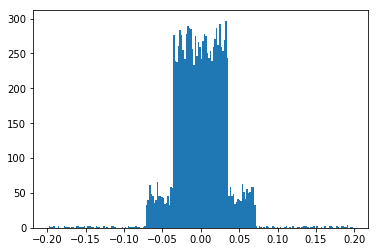

In [36]:
_ = plt.hist(orig_params_flat, bins=200)
plt.show()

In [37]:
final_params = []
for param in best_model.parameters():
  final_params.append(param.data.cpu().numpy().flatten())
final_params_flat = np.concatenate(final_params)

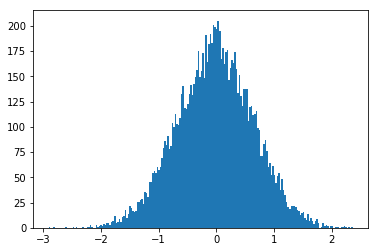

In [38]:
_ = plt.hist(final_params_flat, bins=200)
plt.show()